### Objective
Testing whether or not the global temperater has risen over the period fo 1960 and 2012. 

In [53]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# from fbprophet import Prophet

%matplotlib inline

In [310]:
from scipy.stats import ttest_ind

### Approach 1: at the global-level
First, let's look at the changes in Earth's global average surface temperature. Again, we are focusing on the period of 1960 and 2012 to be consistent with the rest of the analyses. 

#### Data clensing

In [2]:
# bring in the monthly global temperature data
df_temp_raw = pd.read_csv('..\data\GlobalTemperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# define start and end date 
START_DT = '1960-01-01'
END_DT = '2012-12-31'

# create a dataframe for Annualized Average Temperature
df_temp_yr = df_temp_raw.loc[START_DT:END_DT].LandAverageTemperature.resample('A').mean()
df_temp_yr.head()

dt
1960-12-31    8.583750
1961-12-31    8.797667
1962-12-31    8.745917
1963-12-31    8.856000
1964-12-31    8.409667
Freq: A-DEC, Name: LandAverageTemperature, dtype: float64

#### Expoloratory data analysis

In [321]:
pd.DataFrame(df_temp_yr).describe()

,LandAverageTemperature
count,53.000000
mean,9.004667
std,0.386552
min,8.347250
25%,8.692750
50%,8.948250
75%,9.324583
max,9.732167


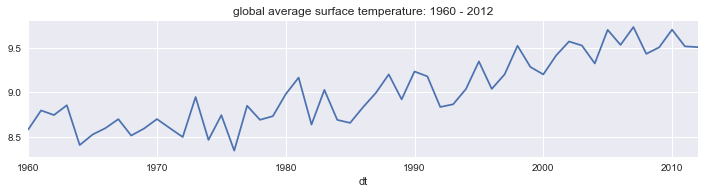

In [330]:
plt.figure(figsize=(12,2.5))
plt.title('global average surface temperature: 1960 - 2012')
df_temp_yr.plot();

The chart above illustrates global average temparature for the period of 1960 to 2012. It appears to have an upward trend but it is hard to confirm that because it fluctuates year by year. Now, let's extract the trend from the chart by removing seasonal component and noises, and for that, we will apply structural modling covered by Week 4 of our course.

#### Modeling: Structural Modeling/Decomposition

Structural Modeling views a given time series as a function of a general trend, along with a seasonal cycle.

$xt=Tt+St+Nt$
 
where
$T_t$ = trend component,
$S_t$ = seasonal component,
$N_t$ = noise.

We will essentially estimate the effect that each component has on the series that we are faced with, at different points in that series.

This procedure is so popular that it gets its own function. There are two parameters that we will want to set - first is the model parameter, which we set to 'additive,' as indicated by the above specification. We are also going to need to set the freq parameter, which is referring to the periodicity of the time series. In our case, I explored several options ranging from 20 to 30 years based on the Forbes article, and settled on 25 years.

In [3]:
decomp = seasonal_decompose(x=df_temp_yr, model='additive', freq=25)

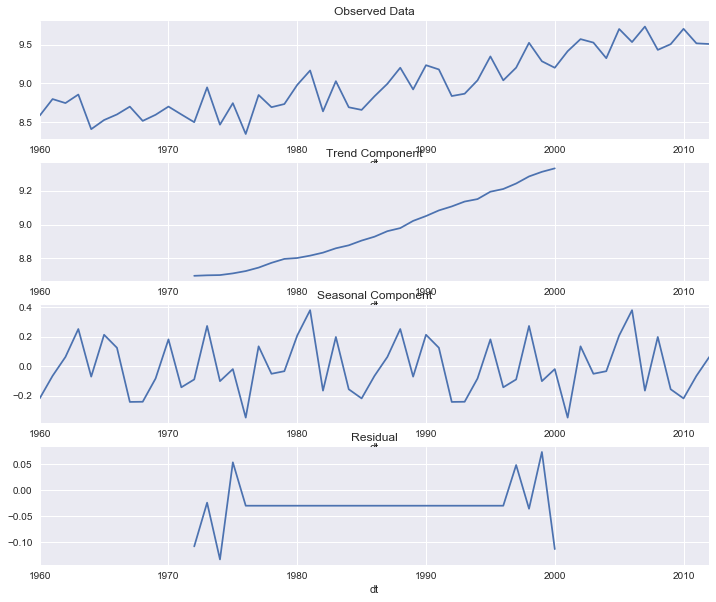

In [4]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10))
decomp.observed.plot(ax=ax1)
ax1.set_title('Observed Data')
decomp.trend.plot(ax=ax2)
ax2.set_title('Trend Component')
decomp.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal Component')
decomp.resid.plot(ax=ax4)
ax4.set_title('Residual');

These results are interesting. First, we are presented with average temperatures. Next, we are given the general trend component. From this, we can see an obvious pattern - global temperature has been increasing over time. We can also see a changepoint occuring right after the trend line becomes available, and we can see that the rate at which average temperature has risen is linear. Now, let's fit a linear line on decomposed trend temperatures and get parameters of the model to better understand the trend.

In [66]:
# quick data cleansing for visuallization
df_trend = pd.DataFrame(decomp.trend).reset_index().dropna()
df_trend['year'] = df_trend.dt.dt.year

C:\Users\m187531\AppData\Local\conda\conda\envs\my_root\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


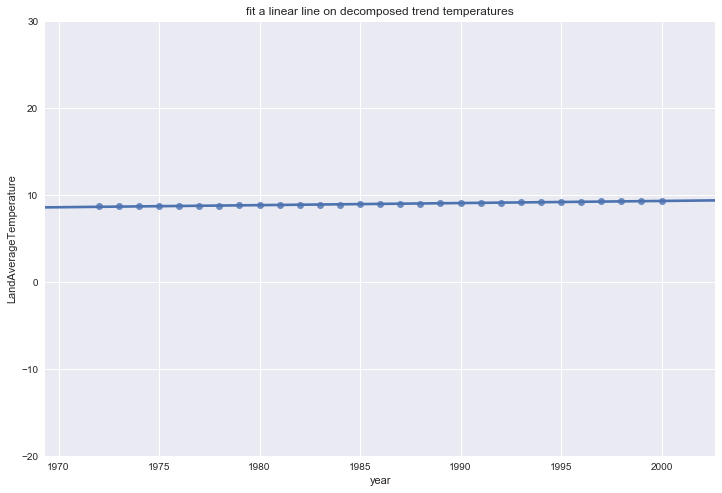

In [332]:
# plot data points and a fitted linear trend line
plt.figure(figsize=(12,8))
plt.ylim(-20, 30)
plt.title('fit a linear line on decomposed trend temperatures')
sns.regplot(x='year', y='LandAverageTemperature', data=df_trend);

In [69]:
# get stats on the fitted line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_trend['year'], df_trend['LandAverageTemperature'])

In [70]:
print('slope: ' + str(slope))
print('p-value: ' + str(p_value))

slope: 0.024073975369458055
p-value: 3.3580736844625425e-25


The fitted trend line has a slope of 0.024 with P-value of 3.35e-25. This indicates that global average temparature has risen by 0.024 celcius degree every year since 1972. The results confirm the upward trend in global temperature during the period .

#### 2) individual view

While our analysis above confirms there is a upward linear trend in global between 1960 and 2012, we would like to investigate further at the country level to get a sense of the varition of trends in temperature at each country. Our questions in this section include:

* Temparature increase observed at the global level is consistent across all countries?
* Is there any variation in temparature change among countries depending on 1) proximity to higher levels Co2 and/or 2) Co2 emission


In [286]:
# load and clean dataset
df_raw = pd.read_csv('../data/ADS_project_dataset2.csv', header=0, parse_dates=[0], squeeze=True)

df_small = df_raw[(df_raw.Year >= 1960) & (df_raw.Year <= 2012)]\
    .loc[:,['Country', 'Year', 'AveTemperature']]\
    .sort_values(['Country', 'Year'])\
    .reset_index(drop=True)

df_small.Year = pd.to_datetime(df_small.Year, format='%Y')
df_small = df_small.set_index('Year')

In [287]:
df_small.head()

,Country,AveTemperature
Year,,
1960-01-01,Afghanistan,13.985417
1961-01-01,Afghanistan,14.064917
1962-01-01,Afghanistan,13.768667
1963-01-01,Afghanistan,15.033417
1964-01-01,Afghanistan,13.084917


In [7]:
df_small.describe()

,AveTemperature
count,9275.000000
mean,18.933613
std,8.694618
min,-19.857750
25%,11.534875
50%,22.365750
75%,26.208792
max,30.127083


In [8]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9275 entries, 1960-01-01 to 2012-01-01
Data columns (total 2 columns):
Country           9275 non-null object
AveTemperature    9275 non-null float64
dtypes: float64(1), object(1)
memory usage: 217.4+ KB


In [9]:
list_country = list(df_small.Country.unique())

In [202]:
df_master_result = pd.DataFrame()

In [203]:
# decompose temperatures for each country
for i in list_country:
    series_temp = df_small[df_small['Country'] == i]['AveTemperature']
    decomp_result = seasonal_decompose(x=series_temp, model='additive', freq=25)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_trend['year'], df_trend['LandAverageTemperature'])
    df_result = pd.DataFrame({'observed': decomp_result.observed,
              'country': i,
              'trend': decomp_result.trend,
              'seasonal': decomp_result.seasonal,
              'resid': decomp_result.resid})
    df_master_result = df_master_result.append(df_result)

In [216]:
# clean data for plotting
df_master_result_sm = df_master_result.dropna().reset_index().loc[:,['Year', 'country', 'trend']]
df_master_result_sm['Year'] = df_master_result_sm['Year'].dt.year

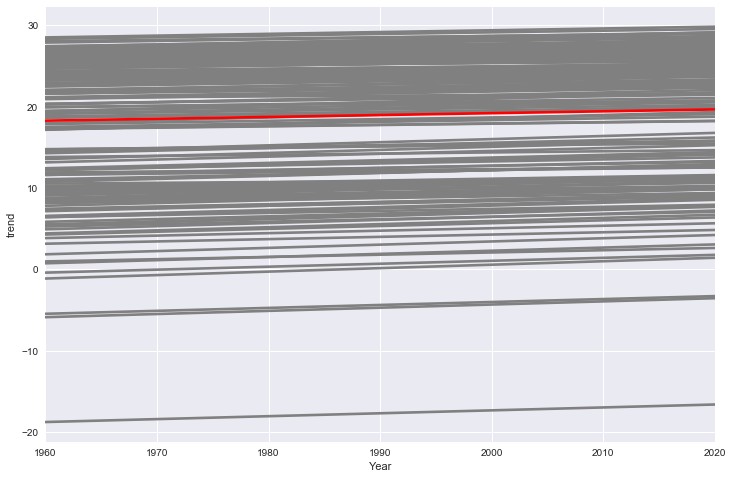

In [246]:
# plot fitted trend lines for all the country in the dataset
plt.figure(figsize=(12,8))
plt.xlim(1960, 2020)
# i = 'Japan'
for i in list_country:
    df_reg = df_master_result_sm[df_master_result_sm['country'] == i]
    sns.regplot(x='Year', y='trend', ci=None, scatter=False, color='grey', data=df_reg)
sns.regplot(x='Year', y='trend', ci=None, scatter=False, color='red', data=df_master_result_sm)

In [255]:
# get stats on the fitted line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_master_result_sm['Year'], df_master_result_sm['trend'])
print('slope: ' + str(slope))
print('p-value: ' + str(p_value))

slope: 0.022989903158485807
p-value: 0.11525080887131027


### countries >80% Co2 within 2000 miles vs. the rest

In [265]:
# get the list of countries >80% Co2 within 2000 miles extracted in notebook 09-hypothesis-test2
country_80pctCO2 = list(pd.read_csv('../data/list_80pctCO2.csv', header=None)[0])

In [273]:
# flag countries >80% Co2 within 2000 miles using the list obove
df_master_result_sm['flag80pctCO2'] = np.where(df_master_result_sm['country'].isin(country_80pctCO2), True, False)

In [277]:
# split the dataset based on whether or not countries >80% Co2 within 2000 miles
df_80pctCO2plus = df_master_result_sm[df_master_result_sm['flag80pctCO2'] == True].reset_index()
df_80pctCO2less = df_master_result_sm[df_master_result_sm['flag80pctCO2'] == False].reset_index()

slope: 0.021396302368047838
p-value: 0.5473317125349675


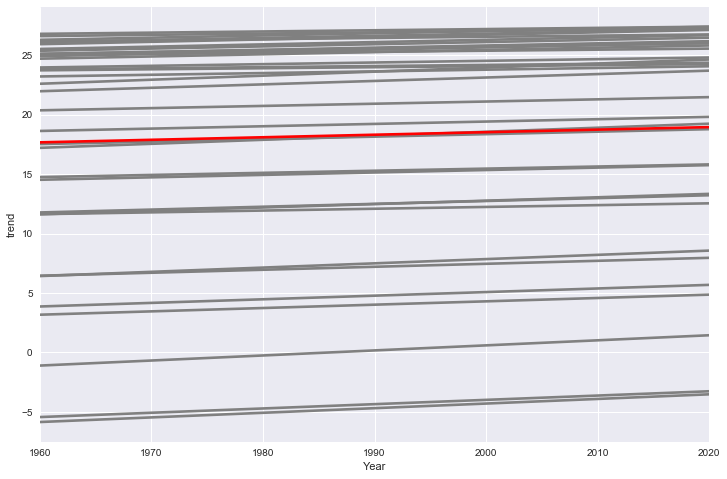

In [281]:
# plot fitted trend lines for all the country in the dataset
list_country_df_80pctCO2plus = df_80pctCO2plus['country'].unique()

plt.figure(figsize=(12,8))
plt.xlim(1960, 2020)
for i in list_country_df_80pctCO2plus:
    df_reg = df_80pctCO2plus[df_80pctCO2plus['country'] == i]
    sns.regplot(x='Year', y='trend', ci=None, scatter=False, color='grey', data=df_reg)
sns.regplot(x='Year', y='trend', ci=None, scatter=False, color='red', data=df_80pctCO2plus)
slope, intercept, r_value, p_value, std_err = stats.linregress(df_80pctCO2plus['Year'], df_80pctCO2plus['trend'])
print('slope: ' + str(slope))
print('p-value: ' + str(p_value))

slope: 0.023388303356095277
p-value: 0.14191839073707133


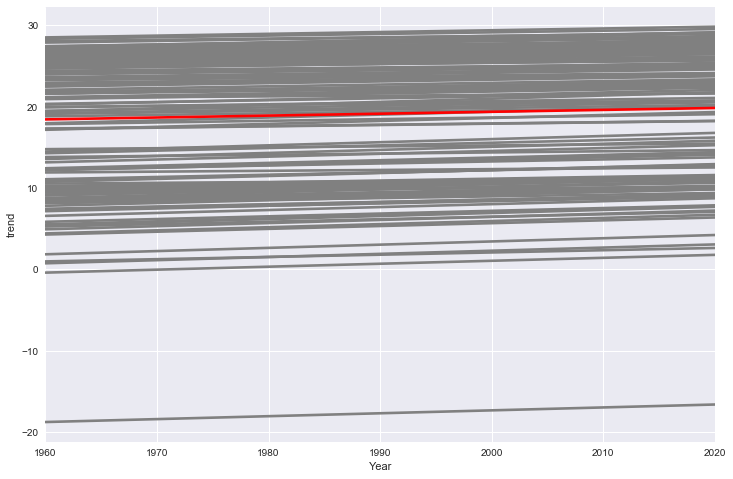

In [283]:
# plot fitted trend lines for all the country in the dataset
list_country_df_80pctCO2less = df_80pctCO2less['country'].unique()

plt.figure(figsize=(12,8))
plt.xlim(1960, 2020)
for i in list_country_df_80pctCO2less:
    df_reg = df_80pctCO2less[df_80pctCO2less['country'] == i]
    sns.regplot(x='Year', y='trend', ci=None, scatter=False, color='grey', data=df_reg)
sns.regplot(x='Year', y='trend', ci=None, scatter=False, color='red', data=df_80pctCO2less)
slope, intercept, r_value, p_value, std_err = stats.linregress(df_80pctCO2less['Year'], df_80pctCO2less['trend'])
print('slope: ' + str(slope))
print('p-value: ' + str(p_value))

In [ ]:
### top 20 emitters countries vs. the rest

In [298]:
list_top20 = list(df_raw[df_raw['Group'] == 'Top20']['Country'].unique())

In [299]:
# flag countries >80% Co2 within 2000 miles using the list obove
df_master_result_sm['top20_emitter'] = np.where(df_master_result_sm['country'].isin(list_top20), True, False)

In [300]:
# split the dataset based on whether or not countries >80% Co2 within 2000 miles
df_CO2_top20 = df_master_result_sm[df_master_result_sm['top20_emitter'] == True].reset_index()
df_CO2_rest = df_master_result_sm[df_master_result_sm['top20_emitter'] == False].reset_index()

In [301]:
def plot_fitted_trend(df):
    list_country = df['country'].unique()

    plt.figure(figsize=(12,8))
    plt.xlim(1960, 2020)
    for i in list_country:
        df_reg = df[df['country'] == i]
        sns.regplot(x='Year', y='trend', ci=None, scatter=False, color='grey', data=df_reg)
    sns.regplot(x='Year', y='trend', ci=None, scatter=False, color='red', data=df)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['Year'], df['trend'])
    print('slope: ' + str(slope))
    print('p-value: ' + str(p_value))

slope: 0.02593375972391367
p-value: 0.5404958281686449


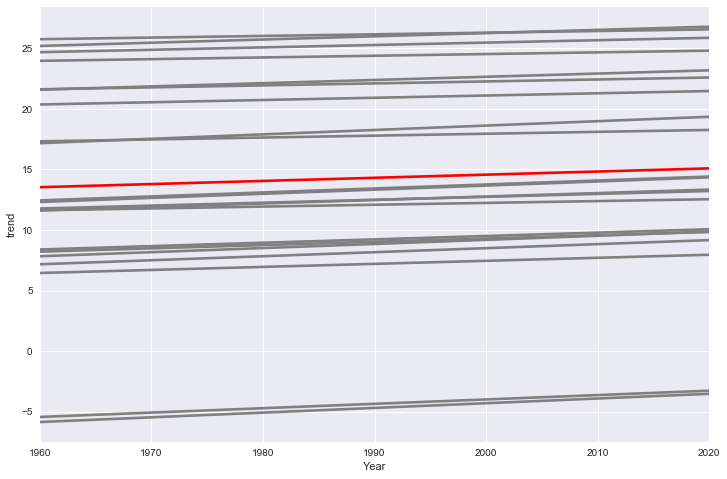

In [302]:
plot_fitted_trend(df_CO2_top20)

slope: 0.022588468172291078
p-value: 0.13722424230081762


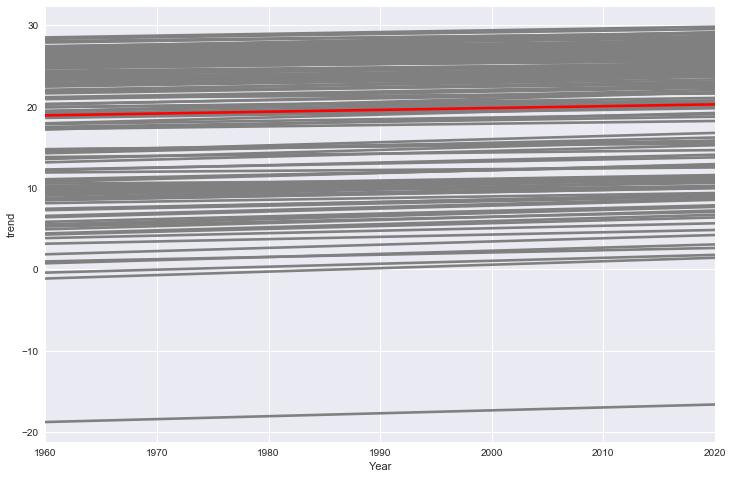

In [303]:
plot_fitted_trend(df_CO2_rest)

In [129]:
# fit a trend line on decomposed trend temparatures
list_country_master = []
list_slope_master = []
list_intercept_master = []
list_r_value_master = []
list_p_value_master = []
list_std_err_master = []

for j in list_country:
    df_result = df_master_result_sm[df_master_result_sm.country == j].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_result.index, df_result.trend)
    list_country_master.append(j)
    list_slope_master.append(slope)
    list_intercept_master.append(intercept)
    list_r_value_master.append(r_value)
    list_p_value_master.append(p_value)
    list_std_err_master.append(std_err)

df_fit = pd.DataFrame(
    {
        'country':list_country_master,
        'slope':list_slope_master,
        'intercept':list_intercept_master,
        'r_value':list_r_value_master,
        'p_value':list_p_value_master,
        'std_err':list_std_err_master
             })

In [153]:
# check the data
df_fit.head()

,country,intercept,p_value,r_value,slope,std_err
0,Afghanistan,13.578291,1.415715e-23,0.988272,0.037527,0.001116
1,Albania,10.975828,4.709614e-17,0.963947,0.024808,0.001318
2,Algeria,19.000433,4.063175e-20,0.978760,0.034009,0.001371
3,Andorra,4.979286,8.427931e-26,0.991989,0.036405,0.000892
4,Angola,16.929805,2.394979e-23,0.987804,0.022256,0.000675


In [304]:
df_fit['flag80pctCO2'] = np.where(df_fit['country'].isin(country_80pctCO2), True, False)
df_fit['top20_emitter'] = np.where(df_fit['country'].isin(list_top20), True, False)

In [305]:
df_fit.head()

,country,intercept,p_value,r_value,slope,std_err,flag80pctCO2,top20_emitter
0,Afghanistan,13.578291,1.415715e-23,0.988272,0.037527,0.001116,False,False
1,Albania,10.975828,4.709614e-17,0.963947,0.024808,0.001318,False,False
2,Algeria,19.000433,4.063175e-20,0.978760,0.034009,0.001371,True,False
3,Andorra,4.979286,8.427931e-26,0.991989,0.036405,0.000892,False,False
4,Angola,16.929805,2.394979e-23,0.987804,0.022256,0.000675,False,False


In [306]:
slope_80pct_true = df_fit[df_fit['flag80pctCO2'] == True]['slope']

In [308]:
slope_80pct_false = df_fit[df_fit['flag80pctCO2'] == False]['slope'] 

In [311]:
ttest_ind(slope_80pct_true, slope_80pct_false)

Ttest_indResult(statistic=-1.2781636285719618, pvalue=0.20290398316510935)

In [312]:
slope_top20emitter_true = df_fit[df_fit['top20_emitter'] == True]['slope']

In [313]:
slope_top20emitter_false = df_fit[df_fit['top20_emitter'] == False]['slope']

In [314]:
ttest_ind(slope_top20emitter_true, slope_top20emitter_false)

Ttest_indResult(statistic=1.75096069316534, pvalue=0.08172511251763438)

In [229]:
# aggregate all the fitted line
grand_intercept = df_fit['intercept'].mean()
grand_slope = df_fit['slope'].mean()

In [240]:
df_fit['intercept'].mean()

-173841.82965339435

In [242]:
grand_slope*1960 

45.06021019063217

In [243]:
grand_intercept

-88.69481104765018

C:\Users\m187531\AppData\Local\conda\conda\envs\my_root\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


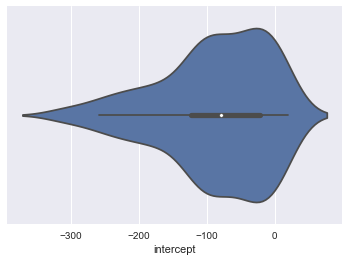

In [238]:
sns.violinplot(df_fit.intercept)

In [136]:
# plot a aggregated trend line
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color='grey')

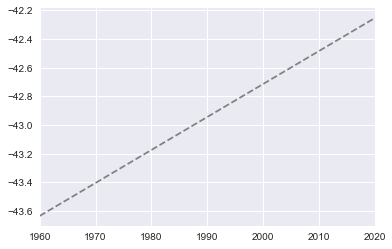

In [232]:
plt.xlim(1960, 2020)
abline(grand_slope, grand_intercept)

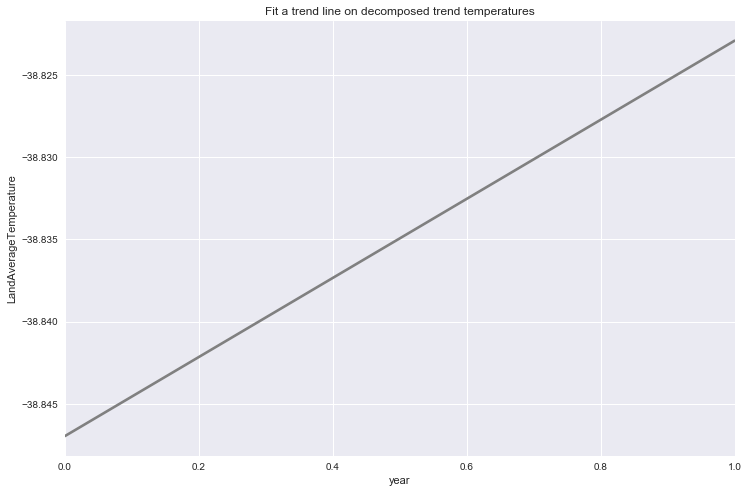

In [152]:
plt.figure(figsize=(12,8))
plt.title('Fit a trend line on decomposed trend temperatures')
sns.regplot(x='year', y='LandAverageTemperature', scatter=False, ci=None, color='grey', data=df_trend)

In [13]:
# transform results for visual
df_trans_result = df_master_result\
    .reset_index()\
    .pivot(index='Year',
           columns='country',
           values='trend')\
    .dropna()

In [14]:
x = np.linspace(0, 15, 31)
data = np.sin(x) + np.random.rand(10, 31) + np.random.randn(10, 1)
df = pd.DataFrame(data).melt()

C:\Users\m187531\AppData\Local\conda\conda\envs\my_root\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


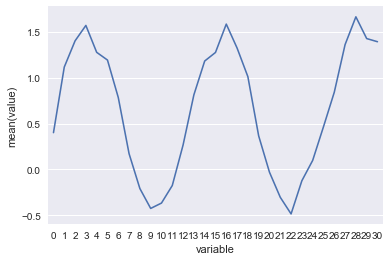

In [73]:
sns.pointplot(x="variable", 
              y="value", 
              scale=0.5, 
              markers='',
              ci=False,
              data=df)

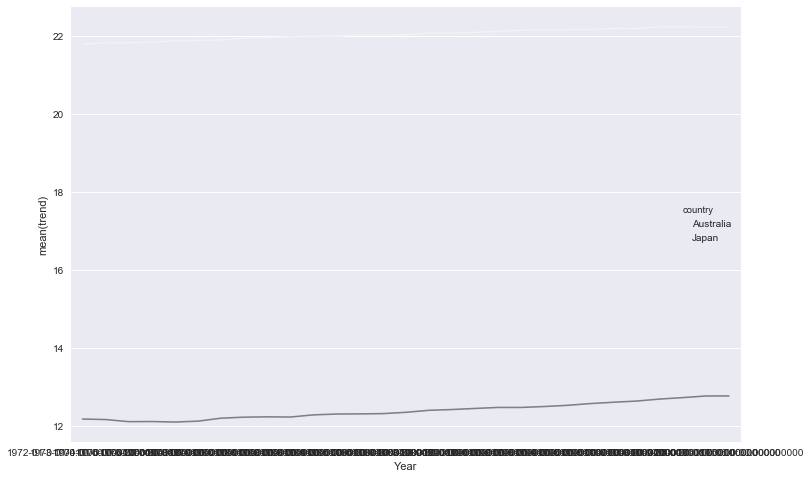

In [82]:
plt.figure(figsize=(12,8))
sns.pointplot(x=df_vis_test.index, 
              y='trend', 
              hue='country', 
              scale=0.5, 
              markers='',
              color='grey', 
              lenged=False, 
              data=df_vis_test)

In [81]:
df_vis_test = df_master_result[df_master_result.country.isin(['Japan', 'Australia'])].dropna()